# Segmentation Client avec K-Means et DBSCAN (sans maintenance)

---

## **Étape 1 : Installation (si nécessaire) et import des bibliothèques**

In [1]:
!pip install pandas numpy sqlalchemy scikit-learn matplotlib seaborn yellowbrick

import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Configuration visuelle
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

Defaulting to user installation because normal site-packages is not writeable


---
## **Étape 2 : Connexion à la base de données et import des tables**

Veillez à adapter le chemin `database_path` selon l’emplacement de votre fichier `olist.db`.


In [2]:
# Connexion SQLite
database_path = "olist.db"  
conn = sqlite3.connect(database_path)

# Chargement des tables nécessaires
customers_df   = pd.read_sql_query("SELECT * FROM customers", conn)
orders_df      = pd.read_sql_query("SELECT * FROM orders", conn)
order_items_df = pd.read_sql_query("SELECT * FROM order_items", conn)
payments_df    = pd.read_sql_query("SELECT * FROM order_pymts", conn)
reviews_df     = pd.read_sql_query("SELECT * FROM order_reviews", conn)

conn.close()

# Vérification
print("customers_df:", customers_df.shape)
print("orders_df:", orders_df.shape)
print("order_items_df:", order_items_df.shape)
print("payments_df:", payments_df.shape)
print("reviews_df:", reviews_df.shape)

customers_df: (99441, 6)
orders_df: (99441, 9)
order_items_df: (112650, 8)
payments_df: (103886, 6)
reviews_df: (99224, 8)


---
## **Étape 3 : Jointures et création du dataset RFM + Review**

Nous allons obtenir, pour chaque client, les variables :
- Frequency (nb de commandes)
- Monetary (somme des paiements)
- Review (note moyenne)
- last_purchase (date de dernière commande)
- Recency (récence en jours)

In [3]:
# 1) Jointure customers -> orders
merged_1 = pd.merge(
    customers_df[['customer_unique_id', 'customer_id']],
    orders_df[['customer_id', 'order_id', 'order_purchase_timestamp']],
    on='customer_id',
    how='left'
)

# 2) merged_1 -> order_items
merged_2 = pd.merge(
    merged_1,
    order_items_df[['order_id','price','freight_value']],
    on='order_id',
    how='left'
)

# 3) merged_2 -> payments
merged_3 = pd.merge(
    merged_2,
    payments_df[['order_id','payment_value']],
    on='order_id',
    how='left'
)

# 4) merged_3 -> reviews
merged_4 = pd.merge(
    merged_3,
    reviews_df[['order_id','review_score']],
    on='order_id',
    how='left'
)

# Agrégation par client
final_df = merged_4.groupby('customer_unique_id').agg({
    'order_id': pd.Series.nunique,    # nb commandes
    'payment_value': 'sum',           # total dépensé
    'review_score': 'mean',           # score moyen
    'order_purchase_timestamp': 'max' # dernière commande
}).reset_index()

# Renommage
final_df.rename(columns={
    'order_id': 'Frequency',
    'payment_value': 'Monetary',
    'review_score': 'Review',
    'order_purchase_timestamp': 'last_purchase'
}, inplace=True)

# Convertir date en datetime
final_df['last_purchase'] = pd.to_datetime(final_df['last_purchase'])

# Calcul de la récence : nb jours entre la dernière commande et la date max
reference_date = final_df['last_purchase'].max()  # ou fixe, 
final_df['Recency'] = (reference_date - final_df['last_purchase']).dt.days

print(final_df.head(5))
print(final_df.shape)

                 customer_unique_id  Frequency  Monetary  Review  \
0  0000366f3b9a7992bf8c76cfdf3221e2          1    141.90     5.0   
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1     27.19     4.0   
2  0000f46a3911fa3c0805444483337064          1     86.22     3.0   
3  0000f6ccb0745a6a4b88665a16c9f078          1     43.62     4.0   
4  0004aac84e0df4da2b147fca70cf8255          1    196.89     5.0   

        last_purchase  Recency  
0 2018-05-10 10:56:27      160  
1 2018-05-07 11:11:27      163  
2 2017-03-10 21:05:03      585  
3 2017-10-12 20:29:41      369  
4 2017-11-14 19:45:42      336  
(96096, 6)


---
## **Étape 4 : Feature Engineering (Transformations, Normalisation)**

- Gérer les NaN sur `Review`.
- Log-transform (pour lisser certaines distributions).
- Normalisation (StandardScaler).

In [4]:
# Imputation Review manquante par la moyenne
mean_review = final_df['Review'].mean()
final_df['Review'] = final_df['Review'].fillna(mean_review)

# Log-transform
final_df['Recency_log']    = np.log1p(final_df['Recency'])
final_df['Frequency_log']  = np.log1p(final_df['Frequency'])
final_df['Monetary_log']   = np.log1p(final_df['Monetary'])
final_df['Review_log']     = np.log1p(final_df['Review'])

# Sélection pour le clustering
features = ['Recency_log', 'Frequency_log', 'Monetary_log', 'Review_log']
X_raw = final_df[features].copy()

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Vérification
X_scaled[:5]

array([[-0.66987625, -0.17359307,  0.15920807,  0.61299843],
       [-0.64011554, -0.17359307, -1.62268498,  0.09687492],
       [ 1.41268181, -0.17359307, -0.38277874, -0.53480921],
       [ 0.67146057, -0.17359307, -1.1185678 ,  0.09687492],
       [ 0.52086811, -0.17359307,  0.51660836,  0.61299843]])

---
## **Étape 5 : Clustering K-Means**

### 5.1 Choix du nombre de clusters (Méthode du coude + Silhouette)

In [5]:
sse = []
k_values = range(1, 9)

for k in k_values:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_scaled)
    sse.append(km.inertia_)

plt.plot(k_values, sse, marker='o')
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie (SSE)")
plt.title("Méthode du coude pour K-Means")
plt.show()

# Silhouette pour k=2..8
sil_scores = []
for k in range(2, 9):
    km_temp = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels_temp = km_temp.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels_temp)
    sil_scores.append(sil)

plt.plot(range(2,9), sil_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Score silhouette")
plt.title("Coefficient de silhouette (K-Means)")
plt.show()

KeyboardInterrupt: 

### 5.2 Entraînement final
Choix : `k=4`

In [ ]:
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, n_init=10, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)

final_df['Cluster_KMeans'] = labels_kmeans

print("Silhouette Score (k=4) =", round(silhouette_score(X_scaled, labels_kmeans), 3))

Silhouette Score (k=4) = 0.356


#### 5.3 Visualisation en 2D (PCA)

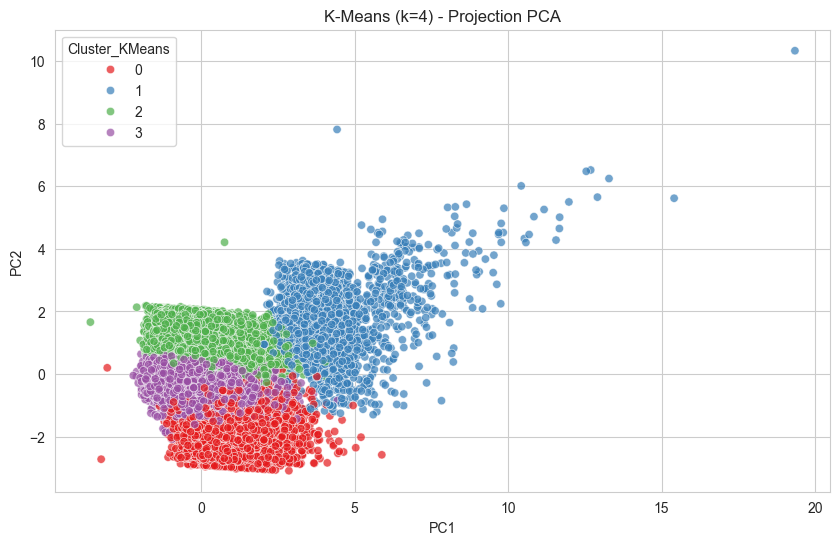

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=['PC1','PC2'])
df_pca['Cluster_KMeans'] = labels_kmeans

sns.scatterplot(data=df_pca, x='PC1', y='PC2',
                hue='Cluster_KMeans', palette='Set1', alpha=0.7)
plt.title("K-Means (k=4) - Projection PCA")
plt.show()

#### 5.4 Profiling des clusters K-Means

In [ ]:
profil_kmeans = final_df.groupby('Cluster_KMeans').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Review': 'mean',
    'customer_unique_id': 'count'
}).rename(columns={'customer_unique_id':'Count'}).reset_index()

profil_kmeans

,Cluster_KMeans,Recency,Frequency,Monetary,Review,Count
0,0,299.307513,1.000000,305.778801,1.200647,13297
1,1,268.206874,2.116116,487.140774,4.106800,2997
2,2,127.765208,1.000000,203.312620,4.587082,29081
3,3,377.575383,1.000000,180.225707,4.551428,50721


### **5.5 Visualisation des distributions de variables par cluster (K-Means)**

Pour mieux **comprendre** comment les variables R, F, M, Review se répartissent dans chaque cluster, nous pouvons tracer des **boxplots**. Cela permet de **visualiser** rapidement les différences entre les clusters K-Means.

/var/folders/9_/gwdhj_ys7pg_ky6kcw839l300000gp/T/ipykernel_23407/156519585.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
/Users/arotanodari/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


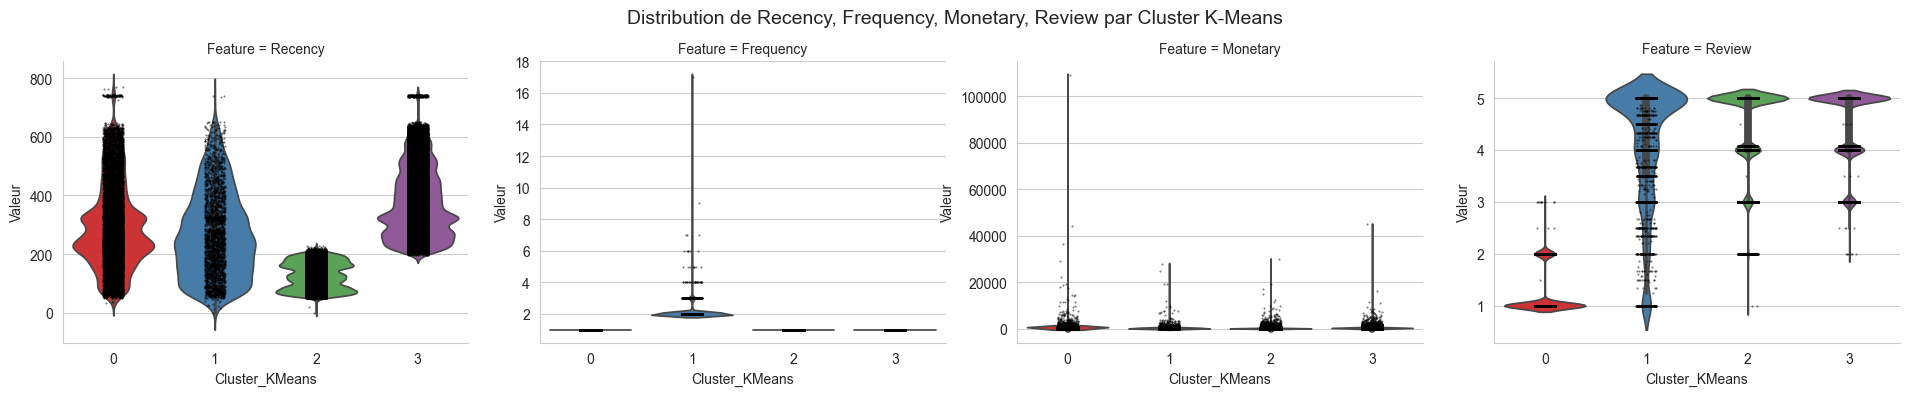

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Préparation des données au format long
melted_kmeans = final_df.melt(
    id_vars='Cluster_KMeans', 
    value_vars=['Recency', 'Frequency', 'Monetary', 'Review'],
    var_name='Feature',
    value_name='Valeur'
)

# ViolinPlot + points individuels
g = sns.catplot(
    data=melted_kmeans,
    x='Cluster_KMeans', 
    y='Valeur',
    col='Feature', 
    kind='violin',
    sharey=False,
    palette='Set1',
    height=4,
    aspect=1.2
)

# Ajout d'un stripplot (ou swarmplot) pour visualiser chaque point
g.map(
    sns.stripplot,
    'Cluster_KMeans', 
    'Valeur',
    color='black',
    size=1.5,
    alpha=0.5,
    jitter=True
)

for ax in g.axes.flat:
    ax.set_xlabel("Cluster_KMeans")
    ax.set_ylabel("Valeur")

plt.subplots_adjust(top=0.85)
g.fig.suptitle("Distribution de Recency, Frequency, Monetary, Review par Cluster K-Means", fontsize=14)

plt.show()


---
## **Étape 6 : Clustering DBSCAN**

### 6.1 Paramétrage et entraînement

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=10)
labels_db = dbscan.fit_predict(X_scaled)

final_df['Cluster_DBSCAN'] = labels_db

unique_labels = set(labels_db)
n_clusters_db = len(unique_labels) - (1 if -1 in unique_labels else 0)
print("Nombre de clusters (hors bruit) =", n_clusters_db)

Nombre de clusters (hors bruit) = 6


### 6.2 Visualisation PCA DBSCAN

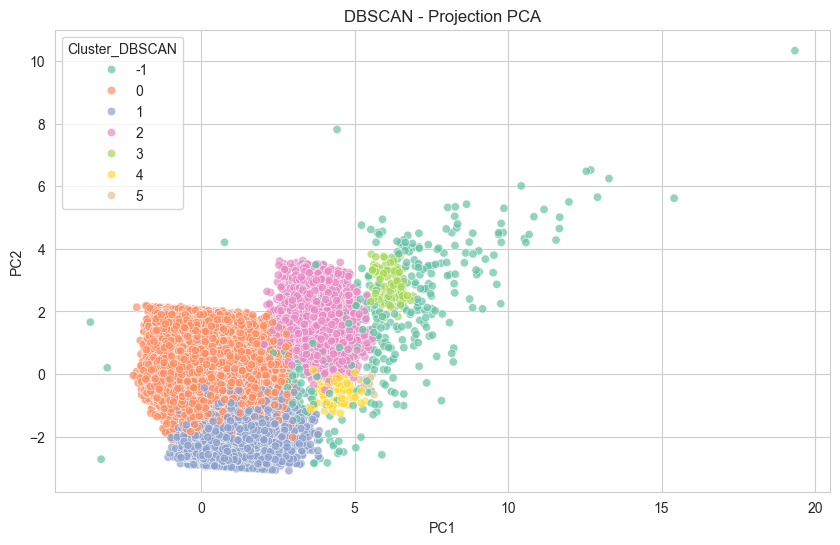

In [ ]:
df_pca['Cluster_DBSCAN'] = labels_db

sns.scatterplot(data=df_pca, x='PC1', y='PC2',
                hue='Cluster_DBSCAN', palette='Set2', alpha=0.7)
plt.title("DBSCAN - Projection PCA")
plt.show()

### 6.3 Profil des clusters DBSCAN

In [ ]:
profil_dbscan = (
    final_df.groupby('Cluster_DBSCAN')
    .agg({'Recency':'mean','Frequency':'mean','Monetary':'mean','Review':'mean'})
    .reset_index()
)

counts_db = final_df['Cluster_DBSCAN'].value_counts(dropna=False)
profil_dbscan['Count'] = profil_dbscan['Cluster_DBSCAN'].map(counts_db)
profil_dbscan

,Cluster_DBSCAN,Recency,Frequency,Monetary,Review,Count
0,-1,225.811671,2.474801,3696.759682,3.015523,377
1,0,287.659608,1.000000,186.128929,4.482661,82408
2,1,294.247126,1.000000,272.981705,1.000000,10614
3,2,270.488827,2.000000,352.961708,4.322784,2506
4,3,275.402174,3.000000,341.696630,4.703804,92
5,4,351.588235,2.000000,261.080235,1.003922,85
6,5,247.071429,2.000000,849.644286,1.000000,14


### **6.4 Visualisation des distributions de variables par cluster (DBScan)**


/var/folders/9_/gwdhj_ys7pg_ky6kcw839l300000gp/T/ipykernel_23407/3291181223.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
/Users/arotanodari/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


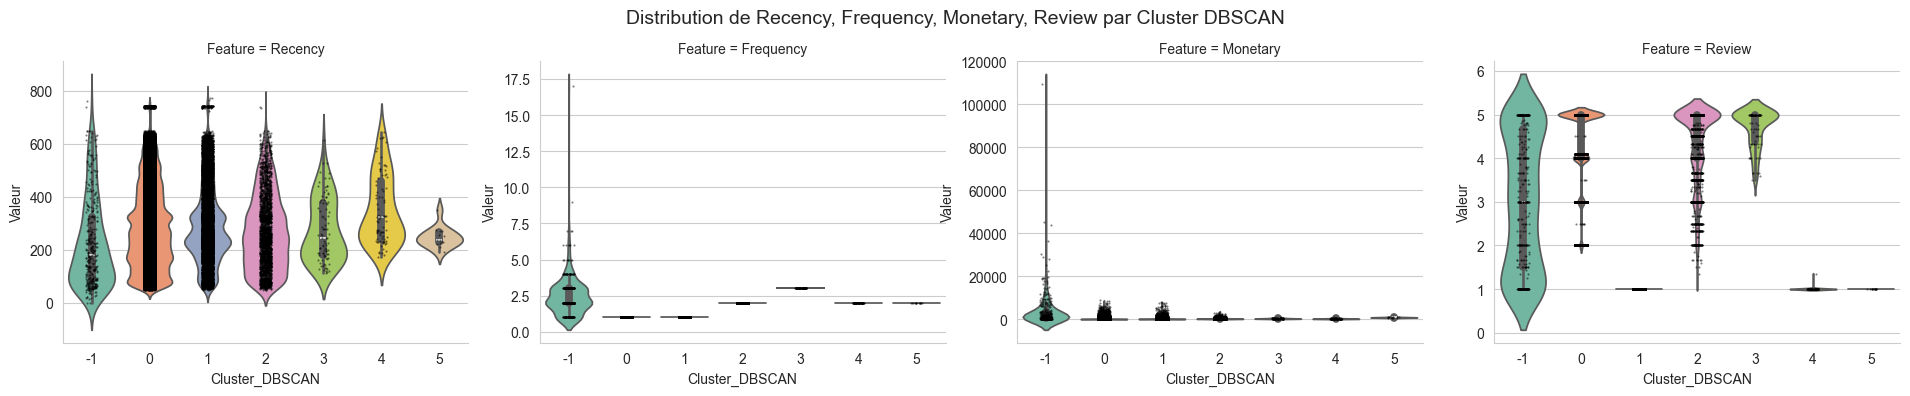

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

# Préparation des données pour un catplot (melt)
melted_dbscan = final_df.melt(
    id_vars='Cluster_DBSCAN',
    value_vars=['Recency', 'Frequency', 'Monetary', 'Review'],
    var_name='Feature',
    value_name='Valeur'
)

# Création d'un ViolinPlot (distributions) + ajout de points individuels
g = sns.catplot(
    data=melted_dbscan,
    x='Cluster_DBSCAN',       # Sur l'axe X : le cluster
    y='Valeur',               # Sur l'axe Y : la valeur numérique
    col='Feature',            # Chaque feature dans une colonne distincte
    kind='violin',            # On veut un ViolinPlot
    sharey=False,             # Chaque subplot a sa propre échelle
    palette='Set2',           # Palette de couleurs
    height=4,                 # Hauteur des graphiques
    aspect=1.2                # Largeur relative
)

# Ajout de points individuels pour voir la répartition exacte (similar stripplot)
# On utilise .map() pour appliquer un stripplot sur chaque subplot existant
g.map(
    sns.stripplot, 
    'Cluster_DBSCAN', 
    'Valeur',
    color='black', 
    size=1.5, 
    alpha=0.5,
    jitter=True
)

# Ajustement des titres
for ax in g.axes.flat:
    ax.set_xlabel("Cluster_DBSCAN")
    ax.set_ylabel("Valeur")

plt.subplots_adjust(top=0.85)
g.fig.suptitle("Distribution de Recency, Frequency, Monetary, Review par Cluster DBSCAN", fontsize=14)

plt.show()
